# Генерация Сигнала

In [208]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
from tqdm import tqdm

import importlib
import model as md
import view as vw

from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer

importlib.reload(md)
importlib.reload(vw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [209]:
def add_realistic_noise(time, signal, F0,
                        low_freq_amp=0.3,
                        harmonic_amp=0.5,
                        white_noise_SNR=40):
    """
    Добавляет типичные физические помехи к сигналу с несущей F0:
      - низкочастотный дрейф (около 0 Гц)
      - вторая гармоника (2*F0)
      - белый шум
    """
    drift = low_freq_amp * np.sin(2*np.pi*1e3*time)
    harmonic = harmonic_amp * np.sin(2*np.pi*(2*F0)*time)

    noise_power = np.mean(signal**2) / (10**(white_noise_SNR / 10))
    white = np.sqrt(noise_power) * np.random.randn(len(signal))
    return signal + drift + harmonic + white

In [210]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]

In [211]:
def circular_hist_mode_deg(angles_deg, nbins=360):
    hist, edges = np.histogram(np.mod(angles_deg + 180, 360) - 180, bins=nbins, range=(-180, 180))
    idx = np.argmax(hist)
    center = 0.5*(edges[idx] + edges[idx+1])
    return center

def circular_mean_deg(angles_deg):
    angles = np.deg2rad(angles_deg)
    c = np.mean(np.exp(1j * angles))
    mean_angle = np.angle(c)  # в радианах
    return np.rad2deg(mean_angle)

def circ_diff_deg(a_deg, b_deg):
    d = (a_deg - b_deg + 180) % 360 - 180
    return d


In [212]:
def find_optimal_params(df):
    # группируем: находим 95-й перцентиль ошибки для каждой пары параметров
    metrics = (
        df.groupby(["order", "band"])["phase_error_deg"]
          .quantile(0.95)  # или median(), mean()
          .reset_index()
    )

    # ищем минимальное значение
    best = metrics.loc[metrics["phase_error_deg"].idxmin()]
    
    return best, metrics.sort_values("phase_error_deg")

In [213]:
def plot_heatmap(df, title):
    # pivot: строки=order, столбцы=band, значение=median error
    pivot = df.pivot_table(index="order", columns="band",
                           values="phase_error_deg", aggfunc="median")

    # логарифм ошибки (+1e-3, чтобы 0 не убивал масштаб)
    log_err = np.log10(pivot + 1e-3)

    plt.figure(figsize=(12,7))
    im = plt.imshow(log_err, aspect='auto', origin='lower',
                    cmap='magma',
                    extent=[pivot.columns.min(), pivot.columns.max(),
                            pivot.index.min(), pivot.index.max()])

    plt.colorbar(im, label="log10(median phase error, deg)")
    plt.title(f"{title}: LOG median phase error")
    plt.xlabel("band half-width (Hz)")
    plt.ylabel("filter order")

    # Contours: границы ошибок 0.1°, 0.5°, 1°, 2°, 5°
    levels = [0.1, 0.5, 1, 2, 5]
    log_levels = np.log10(np.array(levels) + 1e-3)

    cs = plt.contour(log_err, levels=log_levels, colors="white",
                     linewidths=0.8, origin='lower',
                     extent=[pivot.columns.min(), pivot.columns.max(),
                             pivot.index.min(), pivot.index.max()])
    plt.clabel(cs, fmt=lambda v: f"{10**v:.1f}°", colors="white")

    plt.tight_layout()
    plt.show()


In [214]:
def monte_carlo_phase(filter_func,
                      bands=np.arange(10e3, 250e3+1, 10e3),
                      orders=range(2, 10),
                      repeats=10):
    """
    Полное покрытие сетки (band x order) + фазовая ошибка.
    """
    results = []

    # === параметры сигнала ===
    F = 450e3
    fs_mult = 20
    T = 1 / F
    duration = 30 * T
    window_T = 25

    for band in tqdm(bands):
        for order in orders:

            for _ in range(repeats):

                # ---- Генерация сигналов ----
                t = np.arange(0, duration, 1/(fs_mult * F))

                phase = np.random.uniform(1, 180)     # true phase

                U = md.generate_sin(t, F, 3.5)
                I = md.generate_sin(t, F, 0.025, phase)

                U = add_realistic_noise(t, U, F, 0.3, 0.5, 44.3)
                I = add_realistic_noise(t, I, F, 0.003, 0.005, 41.6)

                try:
                    t_f, U_f = filter_func(t, U, F, band, order)
                    _,   I_f = filter_func(t, I, F, band, order)
                except Exception:
                    # недопустимые частоты/заказ фильтра
                    continue

                # ---- фазовые методы ----
                phase_sum = 0
                for method in phase_methods:
                    _, phase_vals = method(t_f, U_f, I_f, F, int(window_T))
                    kde = md.get_kde_mode(phase_vals)
                    phase_sum += kde

                phase_est = phase_sum / len(phase_methods)

                # ---- ошибка ----
                err = (phase_est - phase + 180) % 360 - 180
                err = abs(err)

                results.append({
                    "band": band,
                    "order": order,
                    "phase_error_deg": err
                })

    # === DataFrame ===
    df = pd.DataFrame(results)

    # === строим heatmap ===
    plot_heatmap(df, filter_func.__name__)

    return df


100%|██████████| 25/25 [01:49<00:00,  4.37s/it]


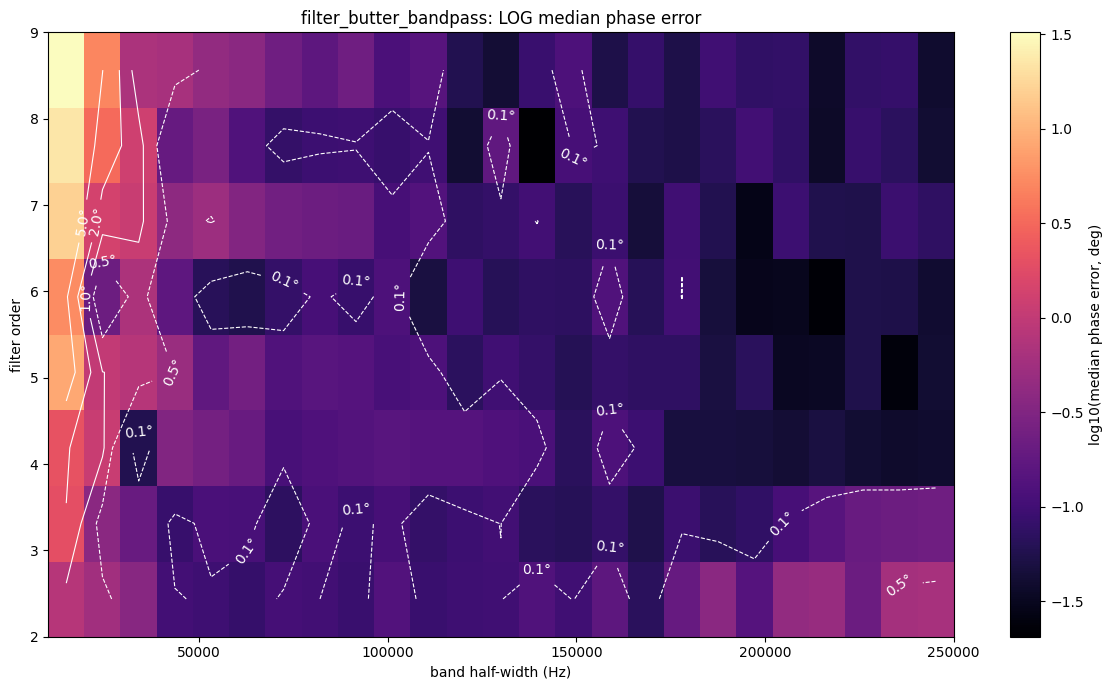

In [215]:
df_butter = monte_carlo_phase(md.filter_butter_bandpass)

100%|██████████| 25/25 [01:49<00:00,  4.36s/it]


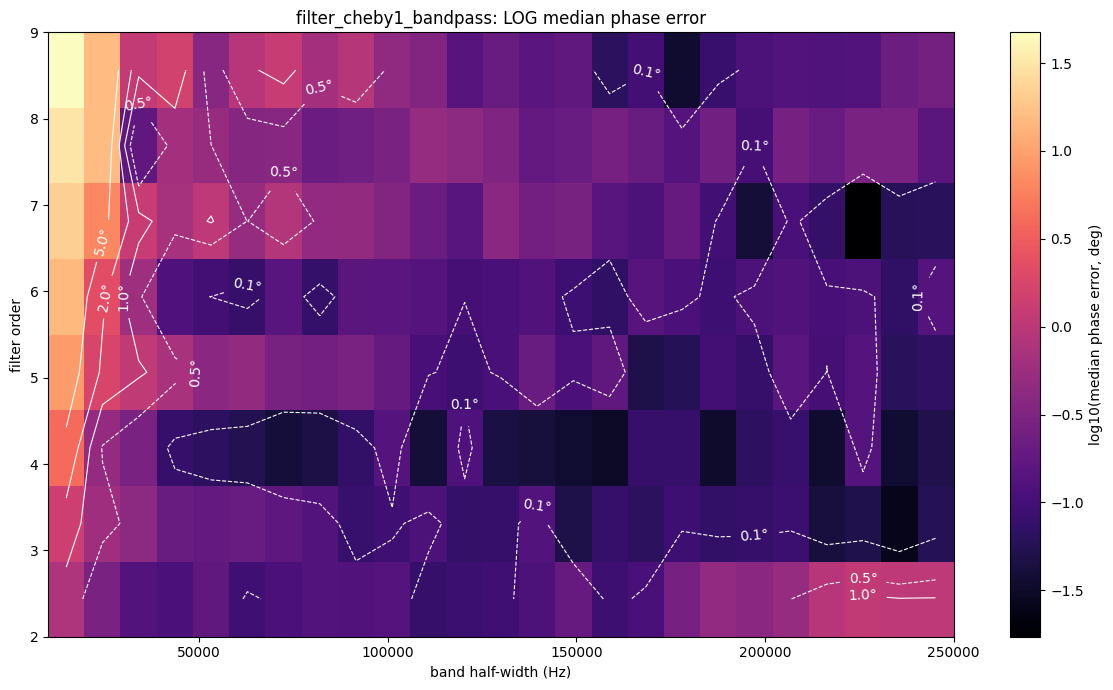

In [216]:
df_cheby1 = monte_carlo_phase(md.filter_cheby1_bandpass)

100%|██████████| 25/25 [01:46<00:00,  4.27s/it]


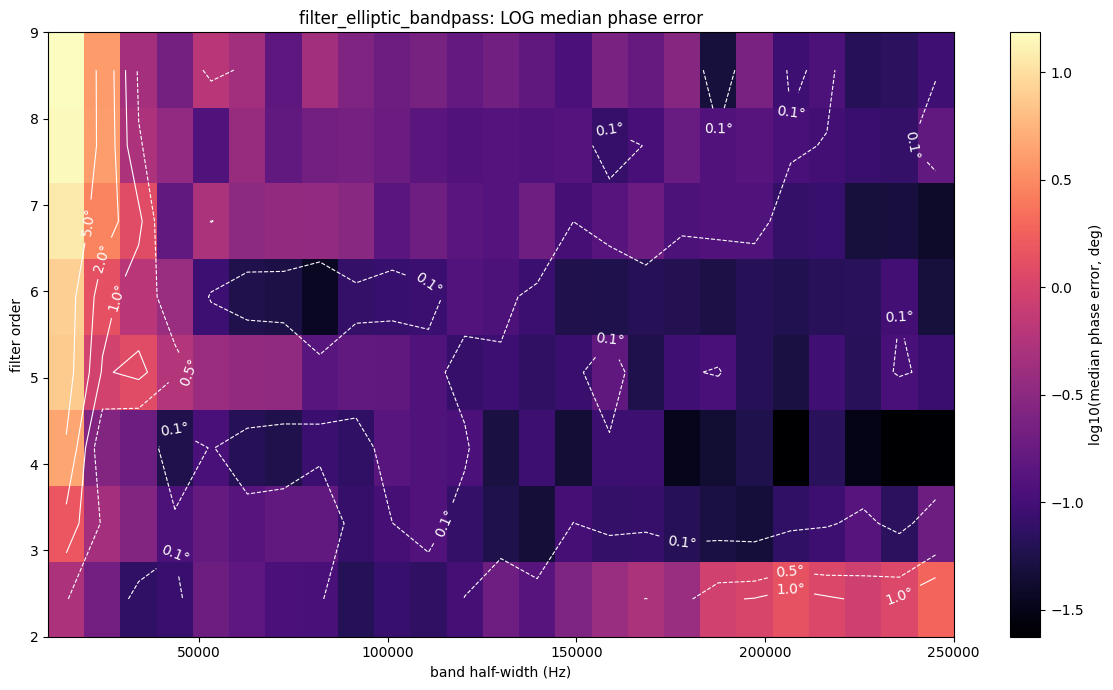

In [217]:
df_elliptic = monte_carlo_phase(md.filter_elliptic_bandpass)

In [218]:
find_optimal_params(df_butter)

(order                   6.000000
 band               210000.000000
 phase_error_deg         0.066803
 Name: 120, dtype: float64,
      order      band  phase_error_deg
 120      6  210000.0         0.066803
 124      6  250000.0         0.071150
 74       4  250000.0         0.071562
 95       5  210000.0         0.072237
 96       5  220000.0         0.072852
 ..     ...       ...              ...
 75       5   10000.0         9.525112
 100      6   10000.0        10.920633
 125      7   10000.0        18.764532
 150      8   10000.0        28.376784
 175      9   10000.0        39.745559
 
 [200 rows x 3 columns])

In [219]:
find_optimal_params(df_cheby1)

(order                   4.000000
 band               160000.000000
 phase_error_deg         0.073944
 Name: 65, dtype: float64,
      order      band  phase_error_deg
 65       4  160000.0         0.073944
 147      7  230000.0         0.079707
 46       3  220000.0         0.091769
 56       4   70000.0         0.094461
 63       4  140000.0         0.100228
 ..     ...       ...              ...
 176      9   20000.0        27.261225
 125      7   10000.0        29.810719
 150      8   10000.0        44.577963
 175      9   10000.0        63.094561
 75       5   10000.0        85.787278
 
 [200 rows x 3 columns])

In [220]:
find_optimal_params(df_elliptic)

(order                   4.000000
 band               250000.000000
 phase_error_deg         0.049478
 Name: 74, dtype: float64,
      order      band  phase_error_deg
 74       4  250000.0         0.049478
 67       4  180000.0         0.064836
 68       4  190000.0         0.065855
 72       4  230000.0         0.072395
 95       5  210000.0         0.082689
 ..     ...       ...              ...
 100      6   10000.0         9.919655
 75       5   10000.0        10.075197
 125      7   10000.0        14.788377
 150      8   10000.0        15.692955
 175      9   10000.0        17.559888
 
 [200 rows x 3 columns])